# **Trabalho Final de PPC - Criação do algoritmo de prova de trabalho paralelo**

##**Definindo um bloco de transações:**

In [0]:
bloco = {
    'tansacoes': [
                    'marcio->tarik:1000 BTC', 
                    'tarik->breno:50 BTC',
                    'felipe->marcio:10 BTC',
                    'marcio->tarik:10 BTC',
                    'marcio->marcio:20 BTC',
                 ],
    'id': 1256,
    'nounce': 0
}

##**Gerando o hash SHA256 do bloco**

In [27]:
import hashlib
bloco_str = str(bloco)
bloco_hash = hashlib.sha256(bloco_str.encode()).hexdigest()
print(f"Hash do bloco {bloco['id']}: {bloco_hash}")

Hash do bloco 1256: f8c38b54620cd1b17be05d31e7e2487407e99facd7c14b82ef7c794a0a965953


##**Implementação serial do algoritmo Hashcash**
Minerando o bloco definido anteriormente 

Definindo a funçao serial que executará o algoritmo POW

In [0]:
from mpi4py import MPI #A impotação está sendo feita aqui para permitir o uso da Wtime

In [0]:
def serial_POW(bloco, qtd_zeros):
  bloco_hash = hashlib.sha256(str(bloco).encode()).hexdigest()
  while bloco_hash[0:N] != '0'*N:
      bloco['nounce'] += 1
      bloco_hash = hashlib.sha256(str(bloco).encode()).hexdigest()
  print(f"Bloco minerado!\nNovo hash: {bloco_hash}")
  print(f"Prova de trabalho: {bloco['nounce']}")

In [0]:
N = 4 #A quantidade de dígitos hexadecimais nulos iniciais do hash

In [31]:
tempo_ini = MPI.Wtime()
serial_POW(bloco, N)
tempo_fin = MPI.Wtime()
tempo_exec_serial = tempo_fin - tempo_ini
print("Tempo de execução serial:", tempo_exec_serial)

Bloco minerado!
Novo hash: 00004b7242cd741ddfa999f2c5ba16876c3202c41b7a33d097890f2e53f3074b
Prova de trabalho: 66546
Tempo de execução serial: 0.23910957399994004


# Implementação paralela do algoritmo Hashcash

A idéia é assumir que os hashs são gerados de maneira aleatória e, portanto, cada um de seus dígitos também é, baseado nisso, pode-se estimar um número de tentativas T suficientes de diferentes valores de nounces que devem ser testados para gerar um hash com os N primeiros dígitos hexadecimais iguais a zero:

* Probabilidade de se gerar um hash com os N dígitos hexadecimais iniciais iguais a zero:

\begin{equation*}
    p = \left( \frac{1}{16} \right)^N
\end{equation*}
    
* Estimativa da quantidade de tentativas necessárias para gerar um hash com os N primeiros dígitos hexadecimais nulos:

\begin{equation*}
    T = \frac{1}{p} = \frac{1}{\left(\frac{1}{16}\right)^N}
\end{equation*}
    
Após a definição de T, cada processo testará uma uma faixa de T/P valores de nounces, onde P é a quantidade de processos em execução. Quando um processo encontrar o nounce que gera o hash adequado, ou seja, a Prova de Trabalho(POW), ele envia uma mensagem a todos os outros processos, que encerram sua execução. Se nenhum processo encontrar a Prova de Trabalho, os próximos T valores de nounces são testados e assim sucessivamente, até que a Prova de Trabalho seja encontrada.

## Definindo o número de dígitos iniciais nulos e calculando a quantidade de tentativas necessárias de nounces para encontrar o hash adequado

In [0]:
import math

In [0]:
T = math.ceil(1/(1/16)**N)

In [34]:
print("Número de tentativas estimado:", T)

Número de tentativas estimado: 65536


## Executando a versão paralela do algoritmo

In [0]:
exec = !mpirun --allow-run-as-root -n 4 python3 parallel_pow.py {bloco['id']} {N} {T}

In [36]:
exec

['Sou o processo 0 e vou testar de 0 até 16384',
 'Hash inicial 634c556fa03420b55a18ab8850079dcc0a64aececcc144b7f51baa6c11699665',
 'Sou o processo 1 e vou testar de 16384 até 32768',
 'Sou o processo 3 e vou testar de 49152 até 65536',
 'Sou o processo 2 e vou testar de 32768 até 49152',
 'O processo 2 encontrou a prova de trabalho',
 'Prova de trabalho 47372',
 'Tempo de execução: 0.10741514500023186']

In [0]:
tempo_exec_paralela = float(exec[-1].split(':')[1])

In [38]:
tempo_exec_paralela

0.10741514500023186

## Cálculo do speedup

> Definindo uma função que obtém os speedups para o número de processos entre 2 e 8:
* A função recebe o id do bloco pois essa é única informação que será modificada em relação ao bloco base e isso é suficiente para produzir um hash único para o novo bloco
* A função também recebe o tempo de execução serial que foi necessário para calcular a prova de trabalho do mesmo bloco

In [0]:
def calcular_speedups(id_bloco, tempo_exec_serial):
    speedups = {}
    for i in range(2, 9):
        exec = !mpirun --allow-run-as-root -n {i} python3 parallel_pow.py {id_bloco} {N} {T}
        t_exec_paralela = float(exec[-1].split(':')[1])
        speedup = tempo_exec_serial/t_exec_paralela
        speedups[i] = speedup
    return speedups

In [40]:
print("Speedups:", calcular_speedups(bloco['id'], tempo_exec_serial))

Speedups: {2: 4.621452643194815, 3: 8.441962577748262, 4: 1.971403704017161, 5: 3.432356474902234, 6: 8.296550563607676, 7: 55.05589618837129, 8: 1.66757597876017}


In [0]:
#!pip3 install matplotlib

In [0]:
import matplotlib.pyplot as plt
import numpy as np

> Definindo uma função para gerar gráficos dos speedups passados como parâmetro em forma de um dicionário onde as chave são a quantidade de processos e os valores são os respectivos speedups.

In [0]:
def gerar_grafico_spd(speedps, limit_y=False):
    speedups = list(speedps.values())
    num_processos = list(speedps.keys())

    fig = plt.figure()
    ax = fig.gca()

    plt.title("Speedup em função do número de processos")
    plt.xlabel("Número de processos")
    plt.ylabel("Speedup")
    
    if limit_y:
        plt.yscale("linear")
        plt.ylim(0, 10)

        ax.set_yticks(np.arange(0, 10., 1))

    plt.plot(num_processos, speedups)
    plt.grid()

    plt.show()

## Gerando blocos aleatórios e calculando os speedups

In [0]:
QTD_BLOCOS = 10

> Definindo uma função que gera blocos "aleatórios" para produzir um conjunto de teste variável, dessa forma pode-se calcular os speedups e demais métricas de maneira mais estatísticamente plausível sobre esse conjunto.

In [0]:
from copy import deepcopy
def gerar_blocos(qtd, bloco_base):
    blocos = []
    for i in range(QTD_BLOCOS):
        novo_bloco = deepcopy(bloco_base)
        novo_bloco['id'] = bloco_base['id'] + i**2
        blocos.append(novo_bloco)
    return blocos

> gerando os blocos aleatórios

In [0]:
blocos = gerar_blocos(QTD_BLOCOS, bloco)

> Calculando os speedups, gerando os gráficos correspondentes e, ao final,  calculando e gerando o gráfico dos speedups médios

Bloco minerado!
Novo hash: 00004b7242cd741ddfa999f2c5ba16876c3202c41b7a33d097890f2e53f3074b
Prova de trabalho: 66546


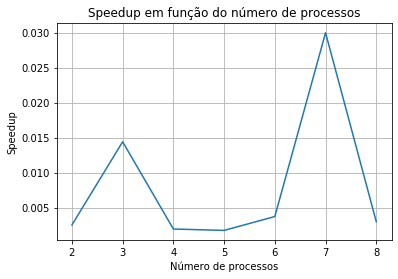

Bloco minerado!
Novo hash: 000043414ba3827f35d8ff8bc6dfe07bca36462545400fe020739025e8783f68
Prova de trabalho: 91597


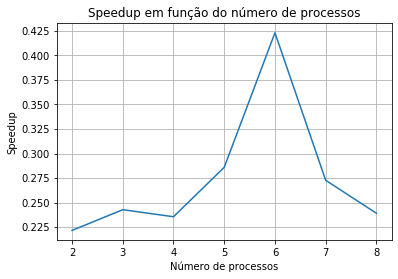

Bloco minerado!
Novo hash: 00002c49bac9e54b61eccceed5b7e9158bc8dcad27b0071dd318515bdeb05a68
Prova de trabalho: 104154


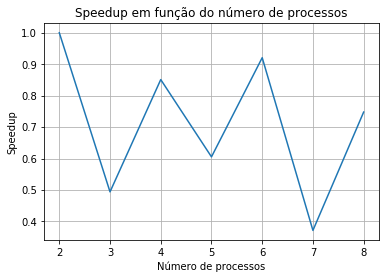

Bloco minerado!
Novo hash: 0000f99fab8224a2ad9975a4e7759be45176401a6a85bbf23f9e9bba57dc2883
Prova de trabalho: 67778


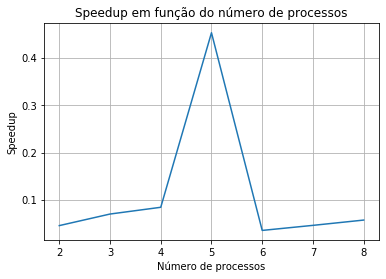

Bloco minerado!
Novo hash: 000064f461d77b41d54e14fba5d69e5a13c1de12aabe23097ca6cf03d127a80e
Prova de trabalho: 184160


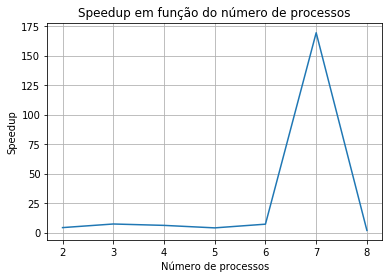

Bloco minerado!
Novo hash: 000063a747b3e50402e92811f0bc3aa13478eeb908ca0ff1947f3946838c5901
Prova de trabalho: 148236


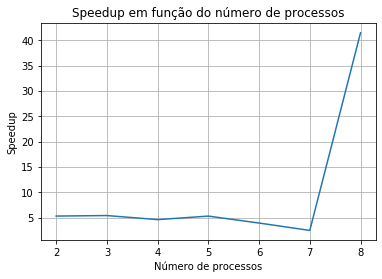

Bloco minerado!
Novo hash: 0000fcbbc1f40850ce6b45e7a48bb88a92e5a5f2d3c0e356d6cfd9f9161c848f
Prova de trabalho: 366208


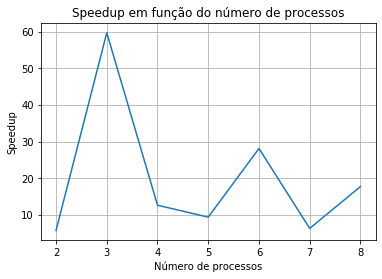

Bloco minerado!
Novo hash: 0000c45f3a52a272b9b557d3a833067cc55d68f10a72ce7f276f633b99eb73d3
Prova de trabalho: 166520


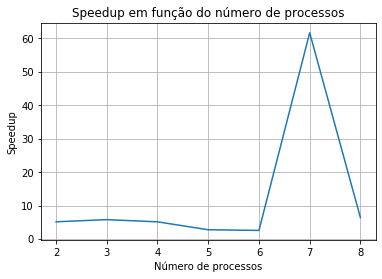

Bloco minerado!
Novo hash: 0000b0114cbe7dc0d1184e8da3282b0fa5dc9fe42efe00baa14d043e05806d3c
Prova de trabalho: 128000


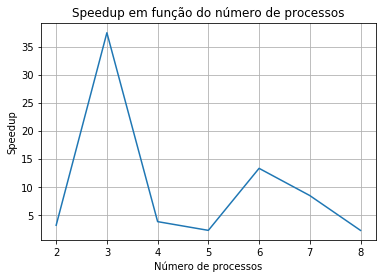

Bloco minerado!
Novo hash: 0000a42bc5dea79763615873603d8e461a28cffd8494b989d700add6412c3523
Prova de trabalho: 101143


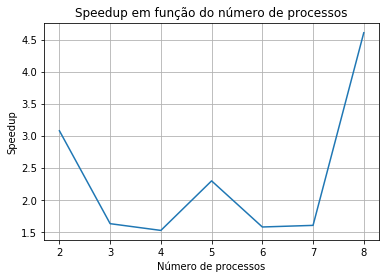



Speedup médio: 



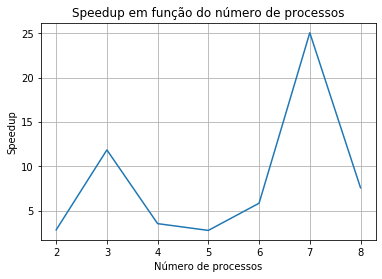

In [47]:
total_processos = 8

speedups_medios = {}

for bloco in blocos:
    
    tempo_ini = MPI.Wtime()
    serial_POW(bloco, N)
    tempo_fin = MPI.Wtime()
    tempo_exec_serial = tempo_fin - tempo_ini
    
    speedups = calcular_speedups(bloco['id'], tempo_exec_serial)
    
    for n_proc, spdp in speedups.items():
        if n_proc in speedups_medios:
            speedups_medios[n_proc] += spdp
        else:
            speedups_medios[n_proc] = spdp
    
    gerar_grafico_spd(speedups, limit_y=False)


for n_proc in speedups_medios:
    speedups_medios[n_proc] /= len(blocos)

print("\n\nSpeedup médio: \n")
gerar_grafico_spd(speedups_medios, limit_y=False)

In [51]:
speedups_medios

{2: 2.8263755868821474,
 3: 11.849532967261768,
 4: 3.5322425854987847,
 5: 2.7667488009127,
 6: 5.836386067471922,
 7: 25.0710856186846,
 8: 7.57397378176655}

> Observe a existência de speedups com valores maiores que 100%, a explicação é mesma dada logo abaixo no cálculo das eficiências.

## Cálculo das eficiências

> Eficiência média em função do número de processos

In [49]:
eficiencias = {}
for n_proc in speedups_medios:
    eficiencias[n_proc] = speedups_medios[n_proc]/n_proc
eficiencias

{2: 1.4131877934410737,
 3: 3.949844322420589,
 4: 0.8830606463746962,
 5: 0.55334976018254,
 6: 0.9727310112453204,
 7: 3.5815836598120856,
 8: 0.9467467227208187}

> Observe que eficiências superiores a 100% são possíveis para esse algoritmo em particular devido a sua natureza probabilística e ao fato de execução terminar assim que um processo encontra o hash

## Cálculo das frações sequenciais

> Frações sequenciais em função dos speedups médios e do número de processos

In [50]:
fracoes_seq = {}
for n_proc in speedups_medios:
    fracoes_seq[n_proc] = (1/speedups_medios[n_proc] - 1/n_proc)/(1 - 1/n_proc)
fracoes_seq

{2: -0.292379962067867,
 3: -0.37341273245584916,
 4: 0.044141684607727605,
 5: 0.20179381647789915,
 6: 0.005606686419870399,
 7: -0.12013231692166834,
 8: 0.008035529310331104}

> A explicação para frações sequenciais negativas é mesma dada para eficiência maior que 100% logo acima